# Final Model


===== Processing AAPL =====
Order (2, 1, 2) - RMSE: 0.7777, Train RMSE: 0.8929, Gap: -0.1152, AIC: 1461.80, BIC: 1542.43
Order (3, 1, 3) - RMSE: 0.7961, Train RMSE: 0.8414, Gap: -0.0452, AIC: 1525.43, BIC: 1615.52
📊 Forecast Accuracy for AAPL: 99.70%

✅ Best model for AAPL: Order (2, 1, 2), RMSE: 0.7777, AIC: 1461.80, BIC: 1542.43


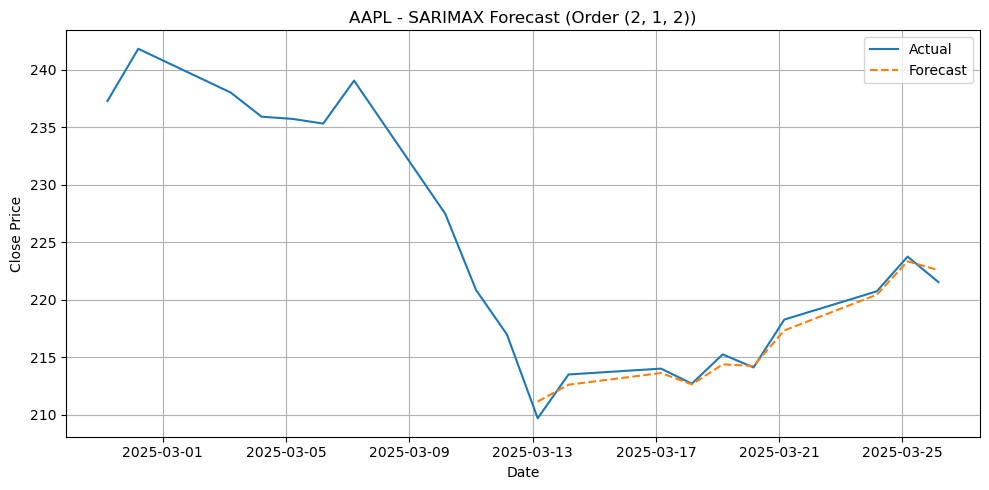


===== Processing META =====
Order (2, 1, 2) - RMSE: 117.2760, Train RMSE: 4.0172, Gap: 113.2588, AIC: 3936.84, BIC: 4017.47
⚠️  Potential overfitting detected (high RMSE gap)
Order (3, 1, 3) - RMSE: 30.3408, Train RMSE: 7.4425, Gap: 22.8984, AIC: 4398.65, BIC: 4488.74
⚠️  Potential overfitting detected (high RMSE gap)
📊 Forecast Accuracy for META: 95.38%

✅ Best model for META: Order (3, 1, 3), RMSE: 30.3408, AIC: 4398.65, BIC: 4488.74


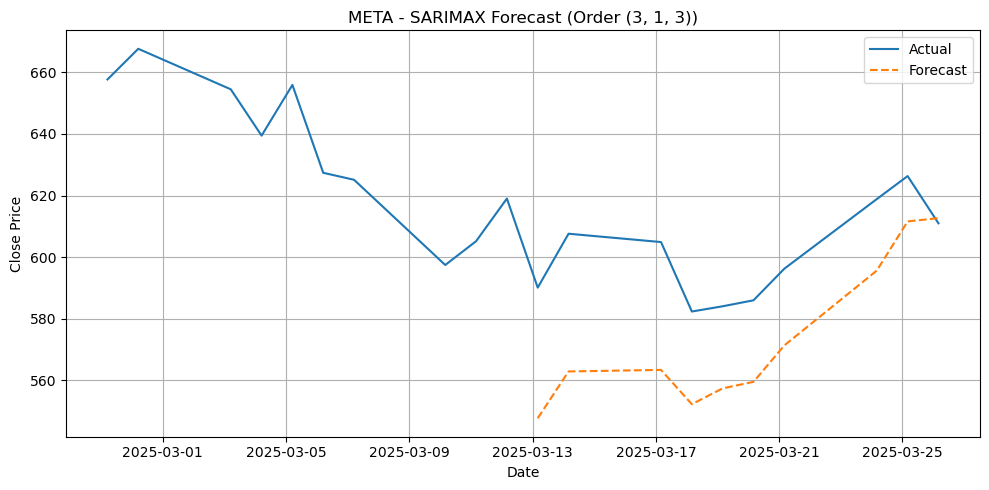


===== Processing GOOGL =====
Order (2, 1, 2) - RMSE: 0.9739, Train RMSE: 0.7692, Gap: 0.2046, AIC: 1758.42, BIC: 1839.05
Order (3, 1, 3) - RMSE: 2.1514, Train RMSE: 0.7777, Gap: 1.3736, AIC: 1766.27, BIC: 1856.37
📊 Forecast Accuracy for GOOGL: 99.51%

✅ Best model for GOOGL: Order (2, 1, 2), RMSE: 0.9739, AIC: 1758.42, BIC: 1839.05


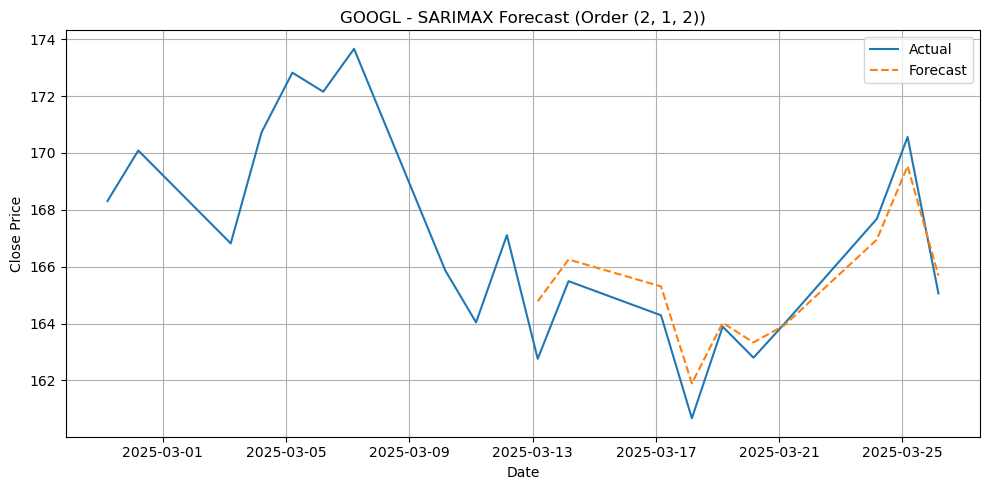


===== Processing AMZN =====
Order (2, 1, 2) - RMSE: 2.2153, Train RMSE: 1.1471, Gap: 1.0683, AIC: 2192.36, BIC: 2273.01
Order (3, 1, 3) - RMSE: 1.8318, Train RMSE: 1.1279, Gap: 0.7039, AIC: 2200.99, BIC: 2291.11
📊 Forecast Accuracy for AMZN: 99.19%

✅ Best model for AMZN: Order (3, 1, 3), RMSE: 1.8318, AIC: 2200.99, BIC: 2291.11


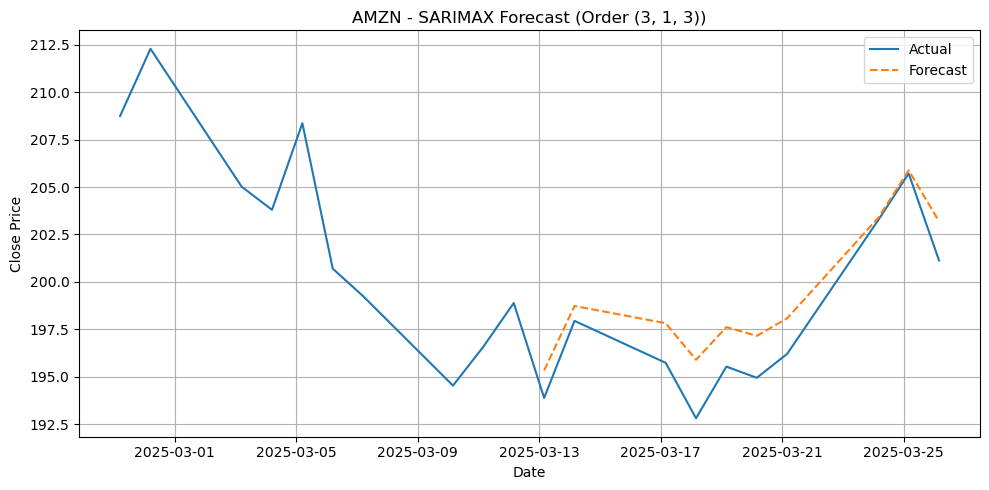


===== Processing NVDA =====
Order (2, 1, 2) - RMSE: 10.6121, Train RMSE: 0.8115, Gap: 9.8006, AIC: 1543.56, BIC: 1624.15
⚠️  Potential overfitting detected (high RMSE gap)
Order (3, 1, 3) - RMSE: 12.5078, Train RMSE: 0.9499, Gap: 11.5579, AIC: 1635.38, BIC: 1725.42
⚠️  Potential overfitting detected (high RMSE gap)
📊 Forecast Accuracy for NVDA: 93.65%

✅ Best model for NVDA: Order (2, 1, 2), RMSE: 10.6121, AIC: 1543.56, BIC: 1624.15


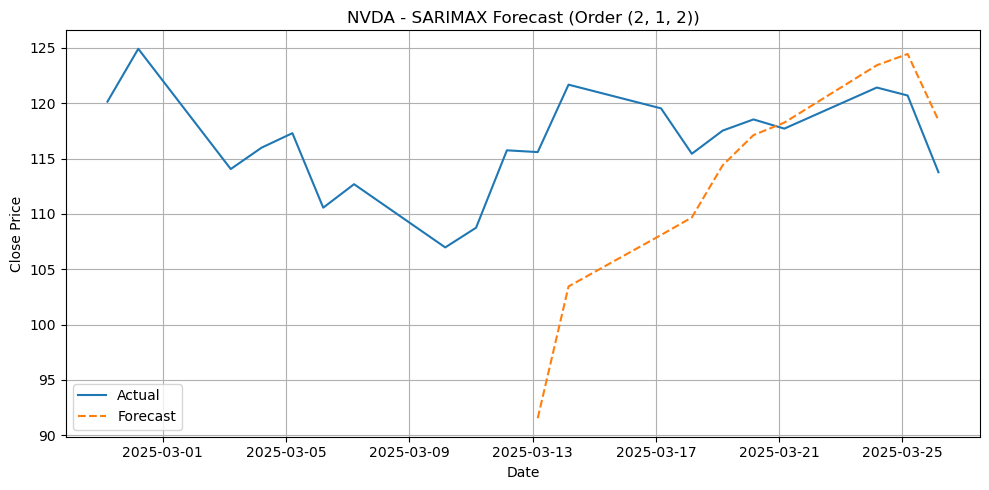


===== Processing MSFT =====
Order (2, 1, 2) - RMSE: 0.9961, Train RMSE: 1.1349, Gap: -0.1389, AIC: 2860.46, BIC: 2941.05
Order (3, 1, 3) - RMSE: 3.1628, Train RMSE: 1.1080, Gap: 2.0547, AIC: 2846.09, BIC: 2936.14
📊 Forecast Accuracy for MSFT: 99.80%

✅ Best model for MSFT: Order (2, 1, 2), RMSE: 0.9961, AIC: 2860.46, BIC: 2941.05


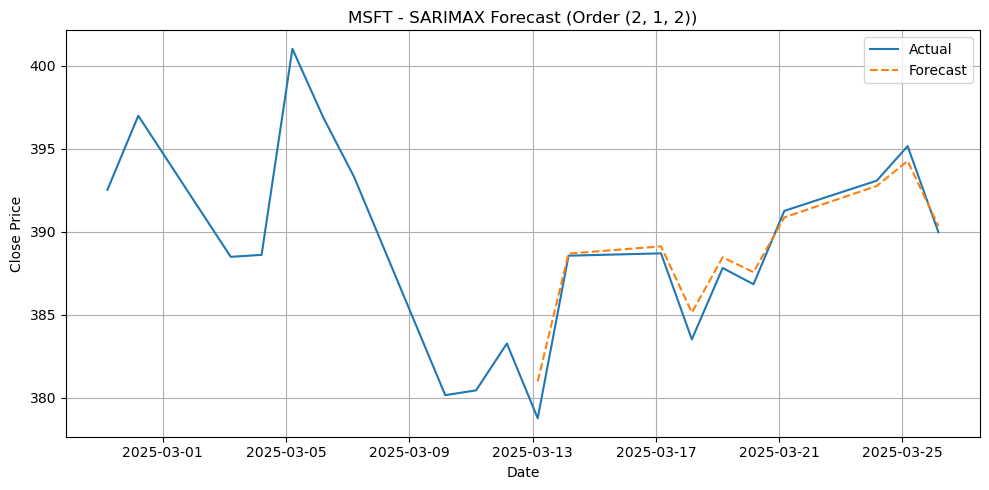


===== Processing TSLA =====
Order (2, 1, 2) - RMSE: 5.0215, Train RMSE: 2.7446, Gap: 2.2768, AIC: 4355.38, BIC: 4436.03
Order (3, 1, 3) - RMSE: 4.3437, Train RMSE: 2.6975, Gap: 1.6462, AIC: 4358.01, BIC: 4448.13
📊 Forecast Accuracy for TSLA: 98.55%

✅ Best model for TSLA: Order (3, 1, 3), RMSE: 4.3437, AIC: 4358.01, BIC: 4448.13


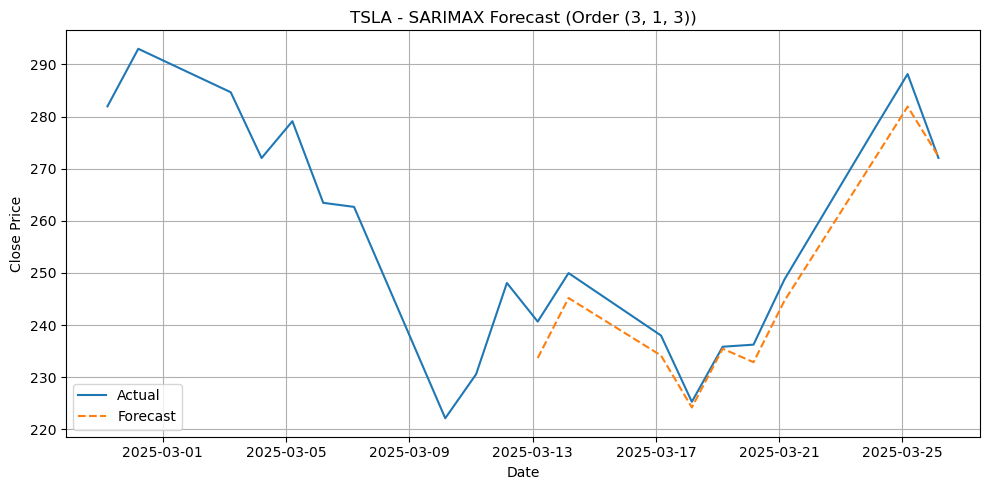

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ------------------------
# 1. Load the dataset
# ------------------------
file_path = "Merged_data_final.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

# ------------------------
# 2. Technical indicators and feature engineering
# ------------------------
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

# ------------------------
# 3. Setup and Configuration
# ------------------------
stocks = df['Stock'].unique()
order_grid = [(2, 1, 2), (3, 1, 3)]

# ------------------------
# 4. Model Training and Feature Importance Analysis
# ------------------------
for stock in stocks:
    print(f"\n===== Processing {stock} =====")
    stock_df = df[df['Stock'] == stock].copy()
    stock_df = add_engineered_features(stock_df)
    stock_df.set_index('Date', inplace=True)
    stock_df = stock_df.sort_index()

    feature_cols = ['sentiment_mean', 'Volume', 'sentiment_count',
                    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
                    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14']

    ts_df = stock_df[['Close'] + feature_cols].dropna()

    if len(ts_df) < 50:
        print(f"Not enough data for {stock}. Skipping.")
        continue

    endog = ts_df['Close']
    exog = ts_df[feature_cols]

    exog_scaled = pd.DataFrame(StandardScaler().fit_transform(exog),
                               index=exog.index, columns=exog.columns)

    best_rmse = float('inf')
    best_forecast = None
    best_order = None
    best_aic = None
    best_bic = None

    for order in order_grid:
        try:
            model = SARIMAX(endog, exog=exog_scaled, order=order, enforce_stationarity=False)
            result = model.fit(disp=False, maxiter=50)
            forecast = result.forecast(steps=10, exog=exog_scaled.iloc[-10:])
            true_values = endog[-10:]
            rmse = np.sqrt(mean_squared_error(true_values, forecast))

            # Overfitting Check: Train RMSE vs Test RMSE
            train_forecast = result.fittedvalues[-len(true_values):]
            train_rmse = np.sqrt(mean_squared_error(true_values, train_forecast))
            rmse_gap = rmse - train_rmse

            aic = result.aic
            bic = result.bic

            print(f"Order {order} - RMSE: {rmse:.4f}, Train RMSE: {train_rmse:.4f}, Gap: {rmse_gap:.4f}, AIC: {aic:.2f}, BIC: {bic:.2f}")

            if rmse_gap > 3:
                print("⚠️  Potential overfitting detected (high RMSE gap)")

            if rmse < best_rmse:
                best_rmse = rmse
                best_forecast = forecast
                best_order = order
                best_aic = aic
                best_bic = bic
        except Exception as e:
            print(f"Error with order {order} for {stock}: {e}")
            continue

    if best_forecast is not None:
        valid_idx = true_values != 0
        if valid_idx.sum() == 0:
            print(f"⚠️  No valid true values for MAPE calculation for {stock}.")
            accuracy = np.nan
        else:
            true_vals = true_values[valid_idx].to_numpy()
            forecast_vals = best_forecast[-len(true_vals):].to_numpy()
            mape = np.mean(np.abs((true_vals - forecast_vals) / true_vals)) * 100
            accuracy = 100 - mape
            print(f"📊 Forecast Accuracy for {stock}: {accuracy:.2f}%")

        print(f"\n✅ Best model for {stock}: Order {best_order}, RMSE: {best_rmse:.4f}, AIC: {best_aic:.2f}, BIC: {best_bic:.2f}")

        # Visualize Forecast vs Actual
        plt.figure(figsize=(10, 5))
        plt.plot(endog[-20:], label='Actual')
        forecast_index = endog.index[-10:]
        plt.plot(forecast_index, best_forecast, label='Forecast', linestyle='--')
        plt.title(f'{stock} - SARIMAX Forecast (Order {best_order})')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

      

# Code for 60 Days


===== Processing AAPL =====
Order (2, 1, 2) - RMSE: 0.0120, AIC: -15527.04, BIC: -15429.61
Order (3, 1, 3) - RMSE: 0.0116, AIC: -15588.42, BIC: -15478.82

✅ Best model for AAPL: Order (3, 1, 3), RMSE: 0.0116, AIC: -15588.42, BIC: -15478.82


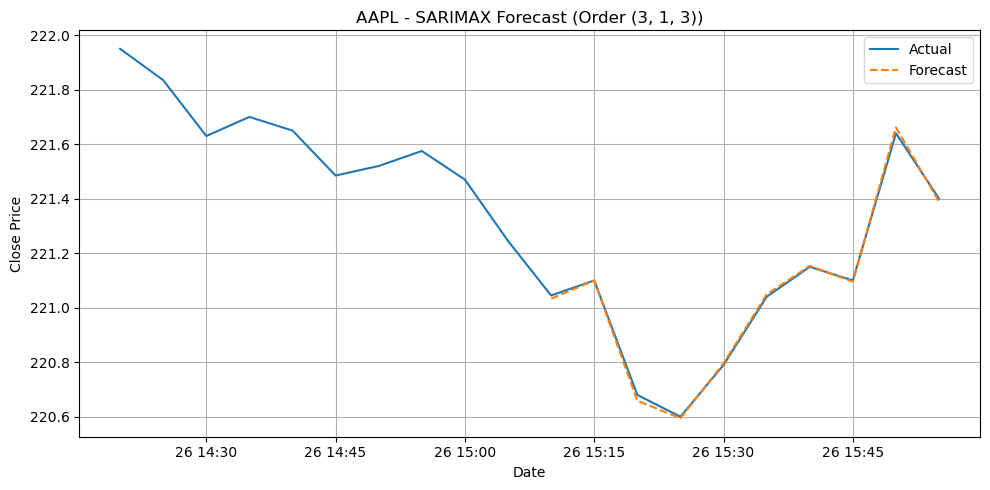


===== Processing META =====
Order (2, 1, 2) - RMSE: 0.0434, AIC: -4792.98, BIC: -4695.55
Order (3, 1, 3) - RMSE: 0.0405, AIC: -4535.05, BIC: -4425.45

✅ Best model for META: Order (3, 1, 3), RMSE: 0.0405, AIC: -4535.05, BIC: -4425.45


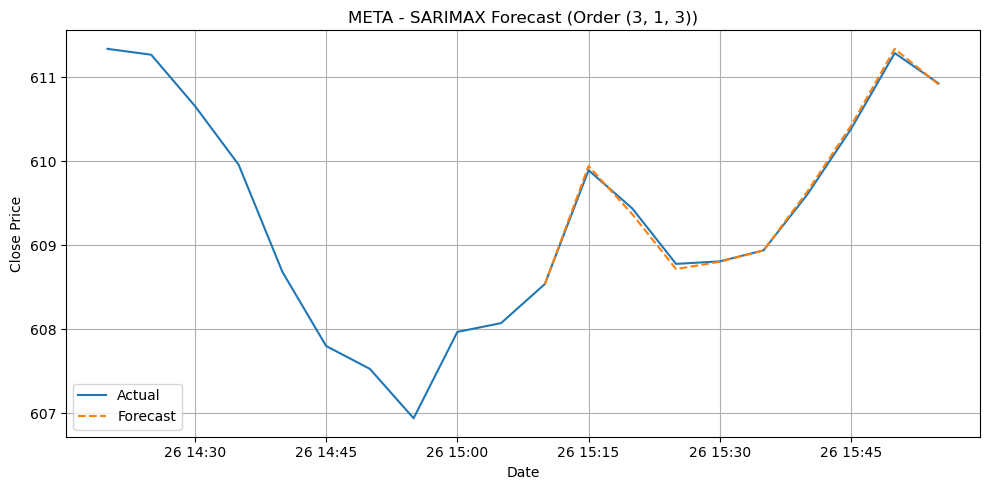


===== Processing NVDA =====
Order (2, 1, 2) - RMSE: 0.0142, AIC: -12357.01, BIC: -12259.58
Order (3, 1, 3) - RMSE: 0.0130, AIC: -12425.12, BIC: -12315.52

✅ Best model for NVDA: Order (3, 1, 3), RMSE: 0.0130, AIC: -12425.12, BIC: -12315.52


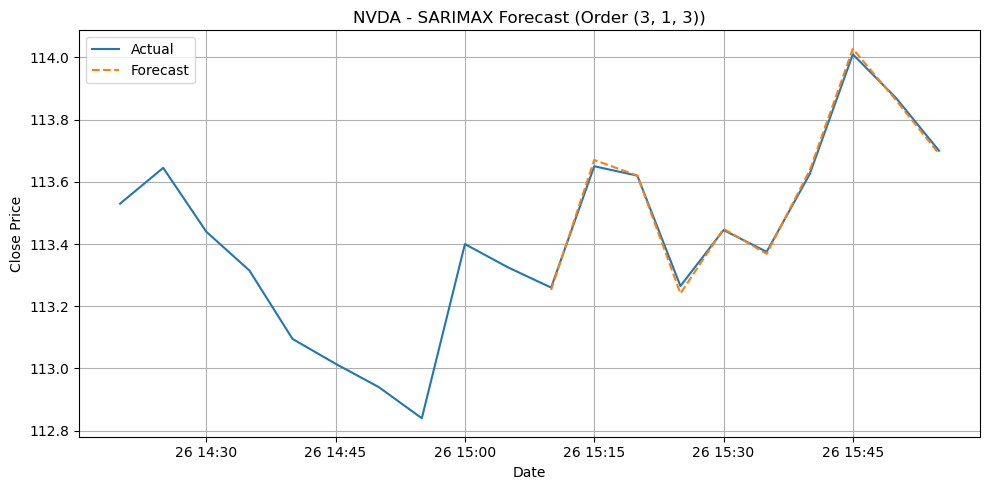


===== Processing GOOGL =====
Order (2, 1, 2) - RMSE: 0.0188, AIC: -10162.66, BIC: -10065.24
Order (3, 1, 3) - RMSE: 0.0204, AIC: -10990.38, BIC: -10880.79

✅ Best model for GOOGL: Order (2, 1, 2), RMSE: 0.0188, AIC: -10162.66, BIC: -10065.24


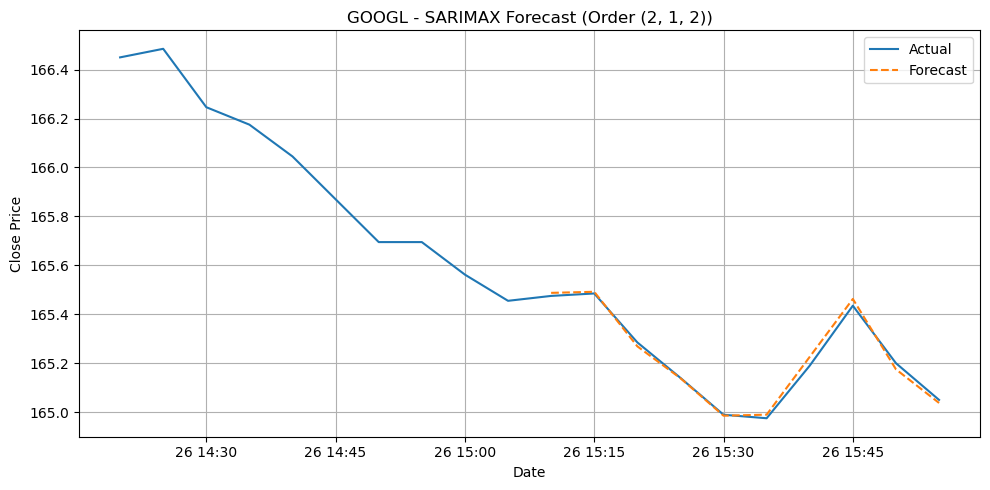


===== Processing TSLA =====
Order (2, 1, 2) - RMSE: 0.1584, AIC: 2007.51, BIC: 2104.94
Order (3, 1, 3) - RMSE: 0.1285, AIC: 2000.30, BIC: 2109.90

✅ Best model for TSLA: Order (3, 1, 3), RMSE: 0.1285, AIC: 2000.30, BIC: 2109.90


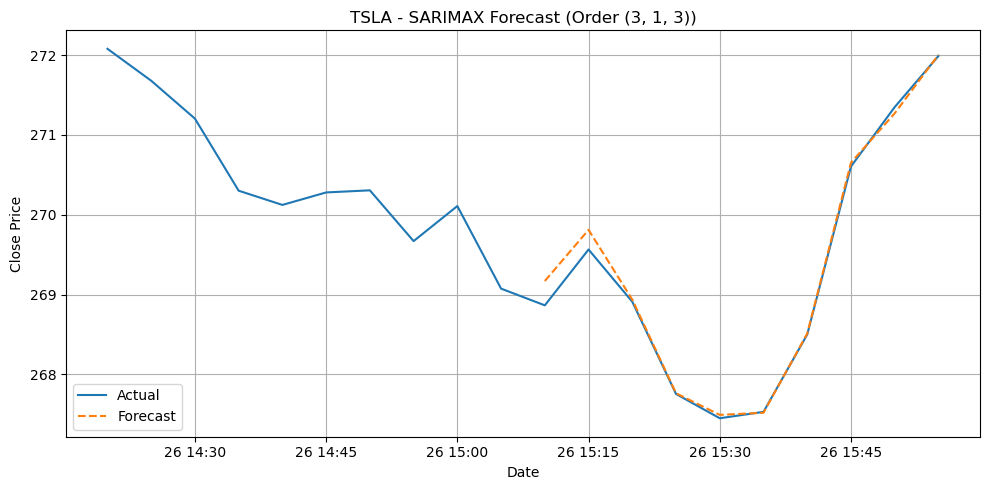


===== Processing AMZN =====
Order (2, 1, 2) - RMSE: 0.0149, AIC: -11982.30, BIC: -11884.88
Order (3, 1, 3) - RMSE: 0.0150, AIC: -12033.23, BIC: -11923.63

✅ Best model for AMZN: Order (2, 1, 2), RMSE: 0.0149, AIC: -11982.30, BIC: -11884.88


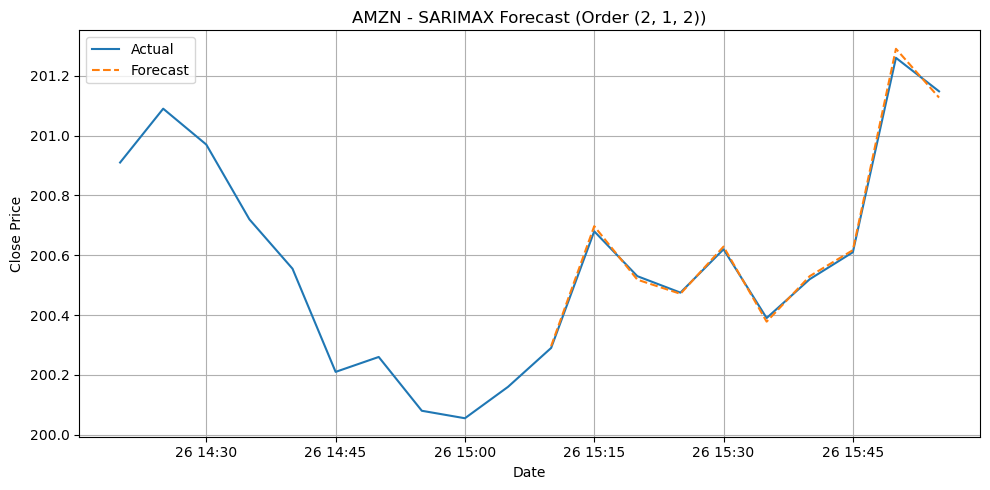


===== Processing MSFT =====
Order (2, 1, 2) - RMSE: 0.0277, AIC: -11091.73, BIC: -10994.30
Order (3, 1, 3) - RMSE: 0.0266, AIC: -11116.33, BIC: -11006.73

✅ Best model for MSFT: Order (3, 1, 3), RMSE: 0.0266, AIC: -11116.33, BIC: -11006.73


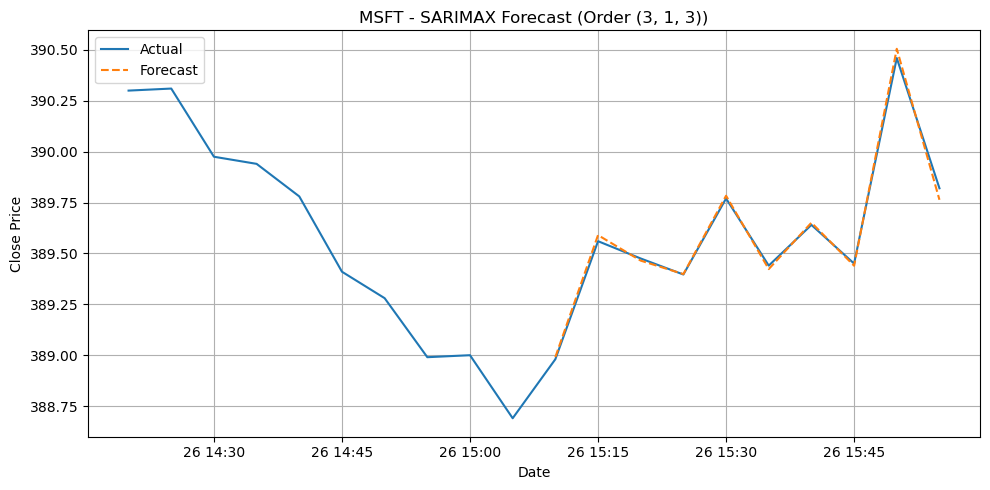

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ------------------------
# 1. Load the dataset
# ------------------------
file_path = "with_faded_sentiment_60.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)
df.drop(columns=['latest_news'], inplace=True)  # Drop unneeded column

# ------------------------
# 2. Technical indicators and feature engineering
# ------------------------
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

# ------------------------
# 3. Setup and Configuration
# ------------------------
stocks = df['Stock'].unique()
order_grid = [(2, 1, 2), (3, 1, 3)]

# ------------------------
# 4. Model Training and Forecast
# ------------------------
for stock in stocks:
    print(f"\n===== Processing {stock} =====")
    stock_df = df[df['Stock'] == stock].copy()
    stock_df = add_engineered_features(stock_df)
    stock_df.set_index('Date', inplace=True)
    stock_df = stock_df.sort_index()

    feature_cols = ['faded_sentiment_score', 'Volume',
                    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
                    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14']

    ts_df = stock_df[['Close'] + feature_cols].dropna()

    if len(ts_df) < 50:
        print(f"Not enough data for {stock}. Skipping.")
        continue

    endog = ts_df['Close']
    exog = ts_df[feature_cols]

    exog_scaled = pd.DataFrame(StandardScaler().fit_transform(exog),
                               index=exog.index, columns=exog.columns)

    best_rmse = float('inf')
    best_forecast = None
    best_order = None
    best_aic = None
    best_bic = None

    for order in order_grid:
        try:
            model = SARIMAX(endog, exog=exog_scaled, order=order, enforce_stationarity=False)
            result = model.fit(disp=False, maxiter=50)
            forecast = result.forecast(steps=10, exog=exog_scaled.iloc[-10:])
            true_values = endog[-10:]
            rmse = np.sqrt(mean_squared_error(true_values, forecast))
            aic = result.aic
            bic = result.bic

            print(f"Order {order} - RMSE: {rmse:.4f}, AIC: {aic:.2f}, BIC: {bic:.2f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_forecast = forecast
                best_order = order
                best_aic = aic
                best_bic = bic
        except Exception as e:
            print(f"Error with order {order} for {stock}: {e}")
            continue

    if best_forecast is not None:
        print(f"\n✅ Best model for {stock}: Order {best_order}, RMSE: {best_rmse:.4f}, AIC: {best_aic:.2f}, BIC: {best_bic:.2f}")
        # Visualize Forecast vs Actual
        plt.figure(figsize=(10, 5))
        plt.plot(endog[-20:], label='Actual')
        forecast_index = endog.index[-10:]
        plt.plot(forecast_index, best_forecast, label='Forecast', linestyle='--')
        plt.title(f'{stock} - SARIMAX Forecast (Order {best_order})')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [5]:
stock_df

,Stock,Open,High,Low,Close,Volume,faded_sentiment_score,EMA_12,EMA_26,MACD,MACD_Signal,RSI_14,Lag_Close,Price_Change_Pct,Volatility_7d,Weekday
Date,,,,,,,,,,,,,,,,
2025-01-27 09:30:00,MSFT,424.209991,425.720001,423.500000,424.660004,5591406,-0.9999,424.660004,424.660004,0.000000,0.000000,NaN,NaN,NaN,NaN,0
2025-01-27 09:35:00,MSFT,424.670013,429.000000,424.410004,428.110992,1194585,-0.8999,425.190925,424.915632,0.275293,0.055059,NaN,424.660004,0.008126,NaN,0
2025-01-27 09:40:00,MSFT,428.149994,428.839996,427.130005,427.480011,727898,-0.8099,425.543092,425.105586,0.437506,0.131548,NaN,428.110992,-0.001474,NaN,0
2025-01-27 09:45:00,MSFT,427.428986,429.579987,427.279999,429.179993,764129,-0.7289,426.102615,425.407394,0.695221,0.244283,NaN,427.480011,0.003977,NaN,0
2025-01-27 09:50:00,MSFT,429.149994,429.429993,427.899994,428.339691,620966,-0.6560,426.446781,425.624601,0.822179,0.359862,NaN,429.179993,-0.001958,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 15:35:00,MSFT,389.765015,389.820007,389.359985,389.440002,162650,-0.0004,389.503800,389.989546,-0.485745,-0.602619,37.118638,389.769989,-0.000847,0.368805,2
2025-03-26 15:40:00,MSFT,389.434998,389.769989,389.341492,389.640015,192366,-0.0004,389.524756,389.963654,-0.438898,-0.569875,44.833526,389.440002,0.000514,0.249441,2
2025-03-26 15:45:00,MSFT,389.635010,389.739990,389.269989,389.450012,145781,-0.0003,389.513257,389.925607,-0.412350,-0.538370,42.787840,389.640015,-0.000488,0.132872,2


# Expected changes for feature engineering in the 60 days model

In [1]:
def add_intraday_features(stock_df):
    stock_df = stock_df.copy()
    
    # Ensure Date is datetime and sorted
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    stock_df.sort_values('Date', inplace=True)
    
    # Extract date and time components
    stock_df['Day'] = stock_df['Date'].dt.date
    stock_df['Time'] = stock_df['Date'].dt.time
    stock_df['Hour'] = stock_df['Date'].dt.hour
    stock_df['Minute'] = stock_df['Date'].dt.minute
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    
    # Intraday rolling stats (over last 1 hour = 12 bars, 2 hours = 24 bars)
    stock_df['Return'] = stock_df['Close'].pct_change()
    stock_df['Rolling_Mean_1h'] = stock_df['Close'].rolling(window=12).mean()
    stock_df['Rolling_Std_1h'] = stock_df['Close'].rolling(window=12).std()
    stock_df['Rolling_Std_2h'] = stock_df['Close'].rolling(window=24).std()
    
    # Price momentum: change over 1 hour
    stock_df['Momentum_1h'] = stock_df['Close'] - stock_df['Close'].shift(12)
    
    # Intraday range (high-low over 1 hour)
    stock_df['Intraday_High_1h'] = stock_df['High'].rolling(window=12).max()
    stock_df['Intraday_Low_1h'] = stock_df['Low'].rolling(window=12).min()
    stock_df['Range_1h'] = stock_df['Intraday_High_1h'] - stock_df['Intraday_Low_1h']
    
    # Volume-based features
    stock_df['Volume_Change'] = stock_df['Volume'].pct_change()
    stock_df['Volume_Surge'] = stock_df['Volume'] / stock_df['Volume'].rolling(window=12).mean()

    # Cumulative returns per day
    stock_df['Daily_Return'] = stock_df.groupby('Day')['Return'].cumsum()

    # Market open and close flags
    stock_df['Is_Open'] = stock_df['Time'].astype(str) == '09:30:00'
    stock_df['Is_Close'] = stock_df['Time'].astype(str) == '16:00:00'

    # Lag features
    stock_df['Lag_Close_1'] = stock_df['Close'].shift(1)
    stock_df['Lag_Close_5'] = stock_df['Close'].shift(5)
    stock_df['Lag_Close_12'] = stock_df['Close'].shift(12)

    return stock_df


# Expected model code for next day prediction:

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
import warnings

warnings.filterwarnings("ignore")

# ========== CONFIG ==========
file_path = "Merged_data_final.csv"  # Ensure this file is in your working directory
output_dir = "sarimax_models"
os.makedirs(output_dir, exist_ok=True)

# Best model orders per stock (from your output)
best_orders = {
    "AAPL": (3, 1, 3),
    "META": (3, 1, 3),
    "NVDA": (3, 1, 3),
    "GOOGL": (2, 1, 2),
    "TSLA": (3, 1, 3),
    "AMZN": (2, 1, 2),
    "MSFT": (3, 1, 3)
}

# ========== STEP 1: Load data ==========
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

# ========== STEP 2: Feature Engineering ==========
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

# ========== STEP 3: Train & Save Models ==========
for stock, order in best_orders.items():
    print(f"\n📈 Training SARIMAX for {stock} with order {order}...")

    stock_df = df[df['Stock'] == stock].copy()
    stock_df = add_engineered_features(stock_df)
    stock_df.set_index('Date', inplace=True)
    stock_df = stock_df.sort_index()

    feature_cols = ['sentiment_mean', 'Volume', 'sentiment_count',
                    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
                    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14']

    ts_df = stock_df[['Close'] + feature_cols].dropna()
    if len(ts_df) < 50:
        print(f"⚠️  Not enough data to train model for {stock}. Skipping.")
        continue

    endog = ts_df['Close']
    exog = ts_df[feature_cols]

    # Scale exogenous variables
    scaler = StandardScaler()
    exog_scaled = pd.DataFrame(scaler.fit_transform(exog), index=exog.index, columns=exog.columns)

    # Train SARIMAX model
    try:
        model = SARIMAX(endog, exog=exog_scaled, order=order, enforce_stationarity=False)
        result = model.fit(disp=False)
        print(f"✅ Model trained for {stock}")

        # Save model & scaler
        model_path = os.path.join(output_dir, f"{stock}_sarimax.pkl")
        scaler_path = os.path.join(output_dir, f"{stock}_scaler.pkl")
        joblib.dump(result, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"💾 Saved model to: {model_path}")
        print(f"💾 Saved scaler to: {scaler_path}")
    except Exception as e:
        print(f"❌ Error training {stock}: {e}")



📈 Training SARIMAX for AAPL with order (3, 1, 3)...
✅ Model trained for AAPL
💾 Saved model to: sarimax_models/AAPL_sarimax.pkl
💾 Saved scaler to: sarimax_models/AAPL_scaler.pkl

📈 Training SARIMAX for META with order (3, 1, 3)...
✅ Model trained for META
💾 Saved model to: sarimax_models/META_sarimax.pkl
💾 Saved scaler to: sarimax_models/META_scaler.pkl

📈 Training SARIMAX for NVDA with order (3, 1, 3)...
✅ Model trained for NVDA
💾 Saved model to: sarimax_models/NVDA_sarimax.pkl
💾 Saved scaler to: sarimax_models/NVDA_scaler.pkl

📈 Training SARIMAX for GOOGL with order (2, 1, 2)...
✅ Model trained for GOOGL
💾 Saved model to: sarimax_models/GOOGL_sarimax.pkl
💾 Saved scaler to: sarimax_models/GOOGL_scaler.pkl

📈 Training SARIMAX for TSLA with order (3, 1, 3)...
✅ Model trained for TSLA
💾 Saved model to: sarimax_models/TSLA_sarimax.pkl
💾 Saved scaler to: sarimax_models/TSLA_scaler.pkl

📈 Training SARIMAX for AMZN with order (2, 1, 2)...
✅ Model trained for AMZN
💾 Saved model to: sarimax_mo